## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Dependencies

In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from moviepy.editor import VideoFileClip

## Functions

In [317]:
def show_img(img):
    """Simple helper function used to visualize output during development
    Takes an np.array image as input - returns nothing"""

    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow(img)
    plt.show()

def calibrateCam(rootpath="./camera_cal/", nx=9, ny=6):
    """calibrateCamera is called to perform calibration on a single camera once at the start of the script
    It acts on all files with a .jpg (case-sensitive) extension contained in rootpath. 
    All qualifying files are expected to have a minimum of nx and ny checkerboard intersections.
    nx and ny are the # of internal corners on checkerboard paper (not img)"""

    calImgPaths = [rootpath + i for i in os.listdir(rootpath) if i[-3:] == 'jpg']

    # For storage of image & object points (img points output of calibration calls)
    # objPts = np.meshgrid()
    imgPts = []
    objPts = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    lastImgSize = 0 # Used in error check for img.shape within loop

    # For each given image
    for path in calImgPaths:

        # Read as grayscale and find corners using fxn params
        img = cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE)
        ok, corners = cv2.findChessboardCorners(img, (nx, ny), None)

        # If corners are returned for a given image
        if ok == True:
            # Add list entry for located corners and unit matrix for each success
            imgPts.append(corners)
            objPts.append(objp)
        
        # Error checking to see if all of the calibration images are of similar resolution
        # Was originally a same-size check, but atleast one of the images is not the same size
        size = np.shape(img)
        if type(lastImgSize) is int:
            pass
        elif (lastImgSize[0] - size[0] > 50) | (lastImgSize[1] - size[1] > 50): 
            raise Exception("Calibration images must all be of similar resolution")
        
        lastImgSize = size
    
    ok, camMat, distortCoeff, rotVec, transVec = cv2.calibrateCamera(objPts, imgPts, size[::-1], None, None)

    return ok, camMat, distortCoeff

def scaleImg(img, nbits=8):
    """scaleImg reduces max value in supplied img to (2^nbits-1)"""

    scale = img.max() / (2**nbits - 1)
    img = img / scale
    return img

def doSobel(img, kernel=9, ddepth=-1):
    """Apply sobel in designated direction. Defaults to 1st order dx
    img: single-channel image to operate on
    theta: can range (-np.pi/2 thru np.pi/2))
    kernel: any odd integer >= 3
    returns: np.array of same shape as img, with sobel applied"""
    
    if kernel % 2 != 1:
        raise Exception("param 'kernel' must be an odd value")

    # Consider eventually adding error-check for single-channel image here

    sobX = cv2.Sobel(img, ddepth, 1, 0, ksize=kernel)
    sobY = cv2.Sobel(img, ddepth, 0, 1, ksize=kernel)

    sobMag = (sobX**2 + sobY**2)**0.5
    sobAngle = np.arctan2(sobX, sobY)

    return sobMag, sobAngle, sobX, sobY 

def makeImgProcHandler(camMat, distortMat):
    """makeImgProcHandler is a function closure that generates the function signature required by
    VideoFileClip.fl_image() method [single parameter for image @ time t]. Generated function
    performs all image processing for this assignment"""

    def ImgProcHandler(img):
        """See docstring for makeImgProcHandler - VideoFileClip.fl_image() method will supply RGB
        image from video file as a numpy array"""

        # Undistort image
        img = cv2.undistort(img, camMat, distortMat, None, camMat)
        
        # Apply logic to find lane lines
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # img to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
        sobMag, sobAngle, sobX, sobY = doSobel(img, ddepth=cv2.CV_64F, kernel=7)

        sobMag = scaleImg(sobMag)
        sobX = scaleImg(abs(sobX))

        # Area useful for lane detection (much broader than lane lines, meant to reject detail irrelevant to lanes)
        laneDetectPts = np.array((((754, 433), (500, 422), (141, 680), (1178, 680))))
        # laneDetectPts = np.array((((433, 754), (422, 500), (680, 141), (680, 1178))))
        # laneDetectRegion = cv2.fillPoly(np.zeros_like(img), np.int32([points]), 255)
        laneDetectRegion = cv2.fillPoly(np.zeros_like(img), np.int32([laneDetectPts]), 255)

        # Detect left lane
        condition = (sobAngle > np.pi/6) & (sobAngle < 5*np.pi/12) & (sobMag <= 255) & (sobMag > 30) & (laneDetectRegion >= 255)
        laneLeft = scaleImg(np.ma.where(condition, 1, 0))
        # condition2 = (sobAngle > np.pi/6) & (sobAngle < 3.5*np.pi/12) & (sobX <= 255) & (sobX > 30)
        # laneLeft2 = scaleImg(np.ma.where(condition2, 1, 0))

        # Detect right lane
        condition = (sobAngle < -np.pi/6) & (sobAngle > -5*np.pi/12) & (sobX <= 255) & (sobMag > 30) & (laneDetectRegion >= 255)
        laneRight = scaleImg(np.ma.where(condition, 1, 0))
        # condition2 = (sobAngle < -np.pi/6) & (sobAngle > -5*np.pi/12) & (sobX <= 255) & (sobX > 30)
        # laneRight2 = scaleImg(np.ma.where(condition2, 1, 0))

        # Define points manually for perspective transform (could be done algorithmically in the future
        # (i.e. using the lane detection I already performed above)
        lanePoints = np.array([[535,492], [823, 492], [254, 642], [1138, 642]], dtype=np.float32) # Sample points from img 4 tfm
        lanePointsTfm = np.array([[340, 500],[1250, 500],[254, 700], [1139, 700]], dtype=np.float32) # Sample points post-tfm
        
        return laneDetectRegion, laneRight, laneLeft

    return ImgProcHandler

def imageUndistortRoutine(inputFilePath, outputFilePath, camMat, distMat):
    """Strictly used to satisfy deliverables for demonstrating image distortion correction
    Outputs a PDF comparing distorted & undistorted cal. file"""

    x = cv2.imread(inputFilePath)
    y = cv2.undistort(x, camMat, distMat, None, camMat)
    fig = plt.figure(figsize=(9,5))
    fig.add_subplot(121)
    plt.imshow(y)
    fig.add_subplot(122)
    plt.imshow(x)
    plt.suptitle("Corrected Image <--- Original Image ")

    plt.savefig(outputFilePath)

def vidProcRoutine(inputVidPath, outputVidPath, imageProcFunc):
    """vidProcRoutine serves as a simple wrapper function that takes in inputVidPath,
    and writes an altered video to outputVidPath using imageProcFunc"""

    inputVid = VideoFileClip(inputVidPath, audio=False)
    alteredClip = inputVid.fl_image(imageProcFunc)
    alteredClip.write_videofile(outputVidPath)

    return alteredClip

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Cal camera & make imgProcHandler

In [318]:
 # Calibrate the camera
ok, camMat, distortMat = calibrateCam()

# Generate image processing fxn compatible with moviepy's VideoClipFile object
imgHandler = makeImgProcHandler(camMat, distortMat)

### Test image handling

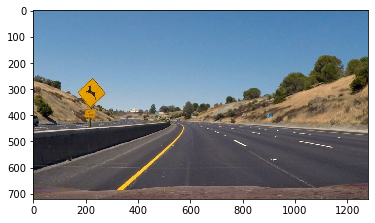

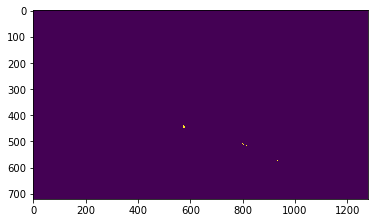

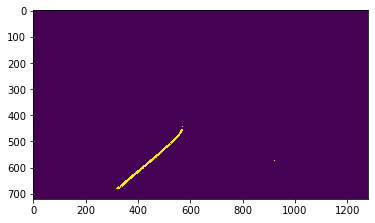

In [319]:
img = mpimg.imread("./test_images/test2.jpg")

region, right, left = imgHandler(img)

plt.imshow(img)
plt.show()
plt.imshow(right)
plt.show()
plt.imshow(left)
plt.show()

### Get project deliverables
#### Undistort a sample calibration image & demo image pipeline on all test images
All test images shown in notebook and saved to file in "./output_images/"

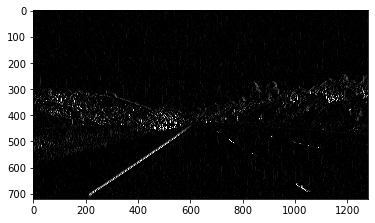

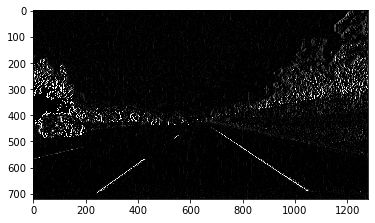

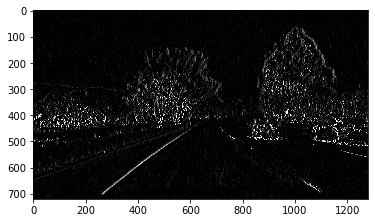

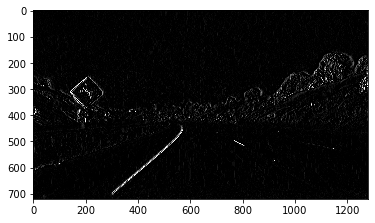

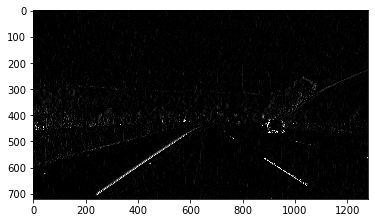

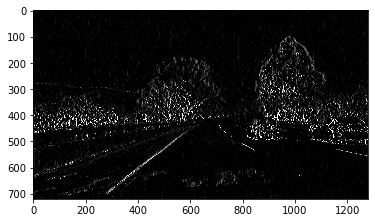

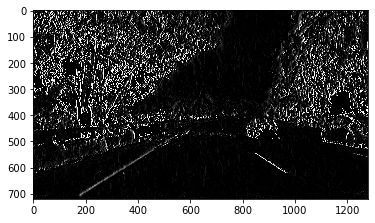

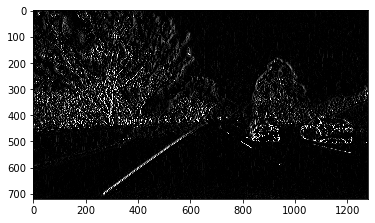

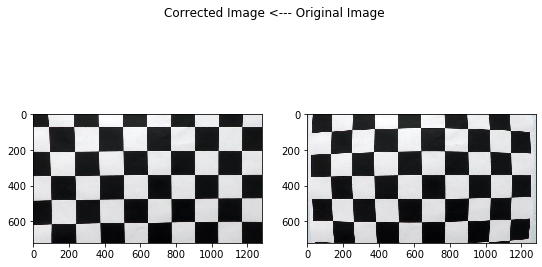

In [22]:
# Fulfill distortion comparison deliverable
imageUndistortRoutine("./camera_cal/calibration1.jpg", "./output_images/calibration1.pdf", camMat, distortMat)

# Execute video processing on test videos of interest
# outputPath = "./test_videos_output/project_video_output.mp4"
# inputPath = "./project_video.mp4"

# alteredVid = vidProcRoutine(inputPath, outputPath, imgHandler)


## Left Lane Test

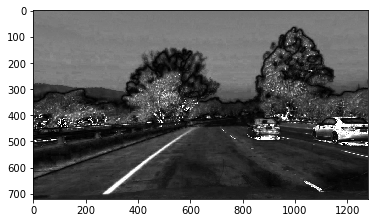

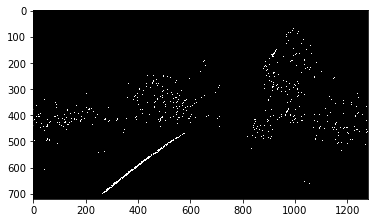

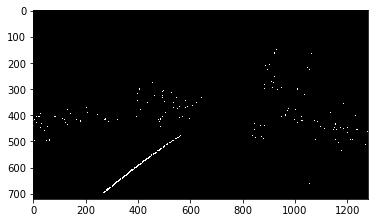

In [261]:
img = mpimg.imread("./test_images/test1.jpg")
# Undistort image
img = cv2.undistort(img, camMat, distortMat, None, camMat)
# Apply logic to find lane lines
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # img to grayscale
img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
sobMag, sobAngle, sobX, sobY = doSobel(img, ddepth=cv2.CV_64F, kernel=7)

sobMag = scaleImg(sobMag)
sobX = scaleImg(abs(sobX))
condition = (sobAngle > np.pi/6) & (sobAngle < 5*np.pi/12) & (sobMag <= 255) & (sobMag > 30)
condition2 = (sobAngle > np.pi/6) & (sobAngle < 3.5*np.pi/12) & (sobX <= 255) & (sobX > 30)
laneLeft = scaleImg(np.ma.where(condition, 1, 0))
laneLeft2 = scaleImg(np.ma.where(condition2, 1, 0))

plt.imshow(img, cmap='gray')
plt.show()
plt.imshow((laneLeft), cmap='gray')
plt.show()
plt.imshow((laneLeft2), cmap='gray')
plt.show()

## Right lane test

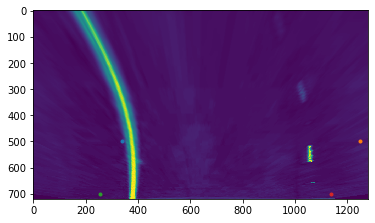

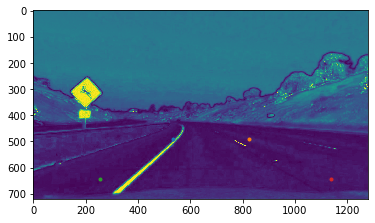

In [255]:
def scaleImg(img, nbits=8):
    """scaleImg reduces max value in supplied img to (2^nbits-1)"""

    scale = img.max() / (2**nbits - 1)
    img = img / scale
    return img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Read and undistort image
img = mpimg.imread("./test_images/test2.jpg")
img = cv2.undistort(img, camMat, distortMat, None, camMat)

# Apply logic to find lane lines
img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
sobMag, sobAngle, sobX, sobY = doSobel(img, ddepth=cv2.CV_64F, kernel=7)

"""(1138-254)/(1020-320)*12*120
= 1818.51428571428571428571

ans/2
= 909.25714285714285714286 fifths of an inch per horiz px on close edge of nearImgLanePoints"""
# 
# 
# 
"""(823-535)/(759-565)*12*120
= 2137.73195876288659793814

ans/2
= 1068.86597938144329896907 fifths of an inch per horiz px on far edge of nearImgLanePoints"""
# 
#
# 
"""50 feet separate these two edges (150 vertical px)"""

# Minimum interstate lane width (12 feet)
# Length of a dash (10 feet)
# Length of spacing between dashes (30 feet)



# Define points we want to use to transform these things
nearImgPerspTransformPts = np.array([[340, 500],[1250, 500],[254, 700], [1139, 700]], dtype=np.float32) # units are in fifths of an inch (909 units per 700px horiz, )
nearImgLanePoints = np.array([[535,492], [823, 492], [254, 642], [1138, 642]], dtype=np.float32)
laneMask = np.array([[760, 420], [582, 420], [254, 642], [1138, 642]], dtype=np.float32) # Used to mask


m = cv2.getPerspectiveTransform(nearImgLanePoints, nearImgPerspTransformPts)

newimg = cv2.warpPerspective(img, m, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# print(transLaneMask)
plt.imshow(newimg)
for i in nearImgPerspTransformPts:
    plt.plot(i[0],i[1], '.')
plt.show()
plt.imshow(img)
for i in nearImgLanePoints:
    plt.plot(i[0],i[1], '.')
plt.imsave("test.png", newimg)

# sobMag = scaleImg(sobMag)
# sobX = scaleImg(abs(sobX))
# condition = (sobAngle < -np.pi/6) & (sobAngle > -5*np.pi/12) & (sobX <= 255) & (sobMag > 30)
# condition2 = (sobAngle < -np.pi/6) & (sobAngle > -5*np.pi/12) & (sobX <= 255) & (sobX > 30)
# laneLeft = scaleImg(np.ma.where(condition, 1, 0))
# laneLeft = region_of_interest()
# laneLeft2 = scaleImg(np.ma.where(condition2, 1, 0))
# plt.imshow(img, cmap='gray')
# plt.show()
# plt.imshow((laneLeft), cmap='gray')
# plt.show()
# plt.imshow((laneLeft2), cmap='gray')
# plt.show()

In [212]:
np.shape(nearImgLanePoints)

(4, 2)

In [208]:
np.shape(img)

(720, 1280)